## Import the Necessary Libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

In [29]:
data = pd.read_csv("Steel_industry_data.csv")
print(data.isnull().sum())  # Count of missing values in each column

data = data.drop(columns=['date'])
X_train=data.values

data.head()


date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [30]:
print(X_train)

[[3.17 2.95 0.0 ... 'Weekday' 'Monday' 'Light_Load']
 [4.0 4.46 0.0 ... 'Weekday' 'Monday' 'Light_Load']
 [3.24 3.28 0.0 ... 'Weekday' 'Monday' 'Light_Load']
 ...
 [3.78 3.17 0.07 ... 'Weekday' 'Monday' 'Light_Load']
 [3.78 3.06 0.11 ... 'Weekday' 'Monday' 'Light_Load']
 [3.67 3.02 0.07 ... 'Weekday' 'Monday' 'Light_Load']]


Feature Scaling

In [31]:
#Feature Scaling
scaler = StandardScaler()


X_train[:, 1:7] = scaler.fit_transform(X_train[:, 1:7]).astype('float64')


print(X_train)
X_train.shape


[[3.17 -0.6185163432975694 -0.5213850478056785 ... 'Weekday' 'Monday'
  'Light_Load']
 [4.0 -0.5259110722465691 -0.5213850478056785 ... 'Weekday' 'Monday'
  'Light_Load']
 [3.24 -0.598278105253311 -0.5213850478056785 ... 'Weekday' 'Monday'
  'Light_Load']
 ...
 [3.78 -0.6050241846013972 -0.5119566216410291 ... 'Weekday' 'Monday'
  'Light_Load']
 [3.78 -0.6117702639494832 -0.5065689495469436 ... 'Weekday' 'Monday'
  'Light_Load']
 [3.67 -0.6142233837124237 -0.5119566216410291 ... 'Weekday' 'Monday'
  'Light_Load']]


(35040, 10)

Column tranforming and label encoding

In [32]:
# Transforming Categorical data into number matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[7,8])],remainder='passthrough')
X_train=ct.fit_transform(X_train)
print(X_train)
print(X_train.shape)



[[1.0 0.0 0.0 ... 0.5132676163619359 -1.6780152604563736 'Light_Load']
 [1.0 0.0 0.0 ... 0.5132676163619359 -1.6419289107691397 'Light_Load']
 [1.0 0.0 0.0 ... 0.5132676163619359 -1.6058425610819058 'Light_Load']
 ...
 [1.0 0.0 0.0 ... 0.5126109334762843 1.6780152604563736 'Light_Load']
 [1.0 0.0 0.0 ... 0.5119542505906323 1.7141016101436073 'Light_Load']
 [1.0 0.0 0.0 ... 0.5126109334762843 -1.7141016101436073 'Light_Load']]
(35040, 17)


In [33]:
#label encoding on the suitable column
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X_train[:,-1]=le.fit_transform(X_train[:,-1])
print(X_train)
type(X_train)
df=pd.DataFrame(X_train)
df.to_csv('scaled_Steel_industry_data.csv', index=False, header=True)

[[1.0 0.0 0.0 ... 0.5132676163619359 -1.6780152604563736 0]
 [1.0 0.0 0.0 ... 0.5132676163619359 -1.6419289107691397 0]
 [1.0 0.0 0.0 ... 0.5132676163619359 -1.6058425610819058 0]
 ...
 [1.0 0.0 0.0 ... 0.5126109334762843 1.6780152604563736 0]
 [1.0 0.0 0.0 ... 0.5119542505906323 1.7141016101436073 0]
 [1.0 0.0 0.0 ... 0.5126109334762843 -1.7141016101436073 0]]


## Federated Learning

In [34]:
#splitting the entire data into 8 nodes to perform FL
node_data = np.array_split(X_train, 8)


In [35]:
global_model = LinearRegression() #Global Model

Funtions for calculating and aggregating the local models 

In [36]:

def federated_averaging(models):
    """Aggregate model weights using the average."""
    coef_avg = np.mean([model.coef_ for model in models], axis=0)
    intercept_avg = np.mean([model.intercept_ for model in models])
    return coef_avg, intercept_avg

# Function to train the local model on each node's data
def train_local_model(data):
  
    y = data[:, 11]   # Target (Usage_kWh)
  
    X = np.concatenate((data[:, :11], data[:, 12:]), axis=1)
    model = LinearRegression()
    model.fit(X, y)
    return model

Federated Learning Process

In [37]:

for iteration in range(3):
    print(f"Iteration {iteration + 1}:")

    # Local models for each node
    local_models = []

    # Train each node's model using 1460 rows in this iteration
    for i, node in enumerate(node_data):
        start = iteration * 1460
        end = start + 1460
        node_subset = node[start:end]

        # Train the local model on the subset
        local_model = train_local_model(node_subset)
        local_models.append(local_model)

        # Evaluate the local model
        y_pred = local_model.predict(np.concatenate((node_subset[:, :11], node_subset[:, 12:]), axis=1))
        mse = mean_squared_error(node_subset[:, 11], y_pred)
        print(f"  Node {i + 1} - MSE: {mse:.4f}")

    # Aggregate the local model updates using Federated Averaging
    coef_avg, intercept_avg = federated_averaging(local_models)

    # Update the global model with aggregated parameters
    global_model.coef_ = coef_avg
    global_model.intercept_ = intercept_avg

    print(f"Global model updated after iteration {iteration + 1}.\n")


Iteration 1:
  Node 1 - MSE: 0.0792
  Node 2 - MSE: 0.0889
  Node 3 - MSE: 0.0827
  Node 4 - MSE: 0.0739
  Node 5 - MSE: 0.0887
  Node 6 - MSE: 0.0345
  Node 7 - MSE: 0.0240
  Node 8 - MSE: 0.0472
Global model updated after iteration 1.

Iteration 2:
  Node 1 - MSE: 0.0596
  Node 2 - MSE: 0.0884
  Node 3 - MSE: 0.0852
  Node 4 - MSE: 0.0703
  Node 5 - MSE: 0.0922
  Node 6 - MSE: 0.0261
  Node 7 - MSE: 0.0231
  Node 8 - MSE: 0.0445
Global model updated after iteration 2.

Iteration 3:
  Node 1 - MSE: 0.0877
  Node 2 - MSE: 0.0838
  Node 3 - MSE: 0.0790
  Node 4 - MSE: 0.0784
  Node 5 - MSE: 0.0471
  Node 6 - MSE: 0.0336
  Node 7 - MSE: 0.0265
  Node 8 - MSE: 0.0630
Global model updated after iteration 3.



Final Evaluation of our Global model

In [38]:
# Final Evaluation (Optional): Use some test data for evaluation
test_data = node_data[0][:1460]  # Example: Using first 1460 rows from node 1 as test data



y_test = test_data[:, 11]   # Target (Usage_kWh)
    # Select all columns except the 12th column using slicing
X_test= np.concatenate((test_data[:, :11], test_data[:, 12:]), axis=1)

df=pd.DataFrame(y_test)
df.to_csv('test_data.csv', index=False, header=True)

y_pred = global_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
print(f"Final Global Model MSE on Test Data: {final_mse:.4f}")

Final Global Model MSE on Test Data: 0.1510


comparing the predicted results vs the actual results

In [39]:
output=np.concatenate((y_pred.reshape(-1,1),y_test.reshape(-1,1)),1)

df=pd.DataFrame(output)
df.to_csv("output.csv", index=False, header=True)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2) #With FL

0.8983988342396683


## Visualizing the Results (FL)

In [41]:
import matplotlib.pyplot as plt

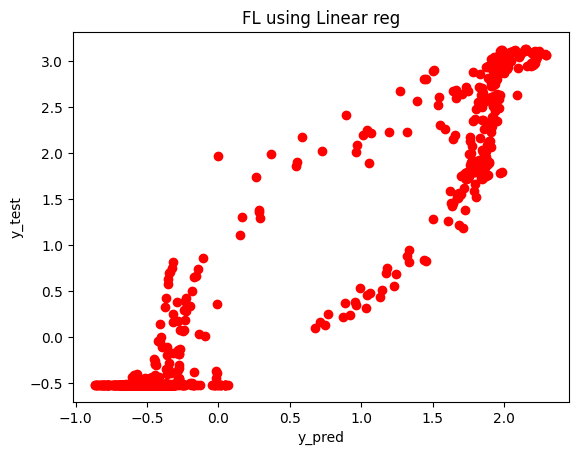

In [42]:
plt.scatter(y_pred,y_test,color='red')

plt.title("FL using Linear reg")
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

## Comparision of Global model if done Without FL

In [43]:
regressor=LinearRegression()
without_FL=X_train

X_withoutFL= np.concatenate((without_FL[:, :11], without_FL[:, 12:]), axis=1)
y_withoutFL = without_FL[:, 11]   # Target (Usage_kWh)


In [44]:
from sklearn.model_selection import train_test_split

X_withoutFL_train, X_withoutFL_test,y_withoutFL_train,y_withoutFL_test = train_test_split(X_withoutFL,y_withoutFL,test_size=0.25,random_state=0)

In [45]:
X_withoutFL_test.shape

(8760, 16)

In [46]:
X_withoutFL_train.shape

(26280, 16)

In [47]:
y_withoutFL_test.shape

(8760,)

In [48]:
y_withoutFL_train.shape

(26280,)

In [49]:
regressor.fit(X_withoutFL_train,y_withoutFL_train)

LinearRegression()

In [50]:
pred=regressor.predict(X_test)

print(pred)

[-0.482499   -0.49030398 -0.48694382 ... -0.51116881 -0.51321488
 -0.51318259]


## Visualising the results (Without FL)

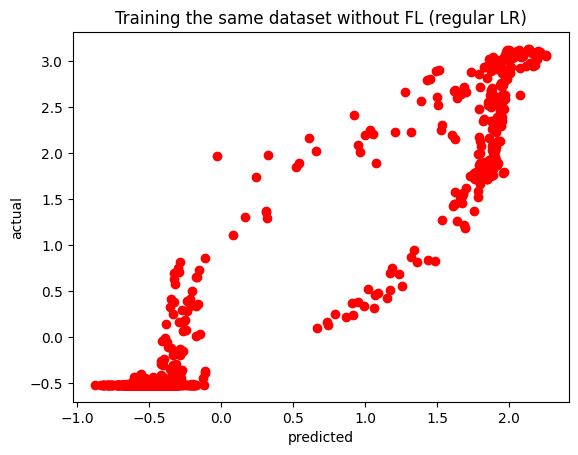

In [51]:
plt.scatter(pred,y_test,color='red')

plt.title("Training the same dataset without FL (regular LR)")
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [52]:
pred.shape

(1460,)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, pred)
print(r2) #Without FL

0.8989506375241366
